# Seal Detection Pipeline
---

This jupyter notebook will go through assembling the main components of a complete pipeline for counting seals in high-resolution satellite imagery (figure 1, steps 3 and 4) and show some experimental results with different pipeline designs. The ultimate goal of this pipeline is to perform a pan-Antarctic pack-ice seal census. ** Running this code will require input satellite imagery and at least one GPU with >8GB of memory **

<br>

<img src="jupyter_notebook_images/Base Pipeline.png">

<br>







## Table of contents
---
* [Getting started](#intro)
    * [Setup](#setup)
    * [Visualize training set](#vis_imgs)
* [Pipeline 1 - Seal haulout detector](#1)
    * [Training](#1T)
    * [Validation](#1V)
* [Pipeline 1.1 - Seal haulout detector + count](#1.1)
    * [Training](#1.1T)
    * [Validation](#1.1V)
    * [Testing](#1.1T)
* [Pipeline 1.2 - Seal haulout detector + single seal detector](#1.2)
    * [Training](#1.2T)
    * [Validation](#1.2V)
    * [Testing](#1.2T)

## Getting started<a name="intro"></a>
---

If you followed the *training_set_generation* jupyter notebook (also present in this repo), you should have training sets generated and hyperparameter sets to try out, and be ready to search for a best performing seal detection pipeline.  Output files in this repository are organized as follows: *'./saved_models_stable/{pipeline}/{model_settings}/{model_settings}_{file}'*

### Setup environment<a name="setup"></a>

Before training and validating model/hyperparameter combinations inside the pipelines, we need to load the required python modules and a few global variables. Running this script will also display a list of training classes.

In [1]:
# import required packages
import os
import rasterio
import pandas as pd
import numpy as np
import operator
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import reduce
from utils.model_library import * 

%matplotlib inline
mpl.rcParams['figure.dpi']= 400

# display class names
class_names = sorted([subdir for subdir in os.listdir('./training_sets/training_set_vanilla/training')])
print(class_names)

# destination folder for saved models and model stats
dest_folder = 'saved_models_stable'

['crabeater', 'crack', 'emperor', 'glacier', 'ice-sheet', 'marching-emperor', 'open-water', 'other', 'pack-ice', 'rock', 'weddell']


### Visualizing training images (Optional)<a name="vis_imgs"></a>

To get a better sense for what the training set is like, the next cell will display a few random images from the training classes. Displayed images are extracted from a pool of ~70000 training images. 

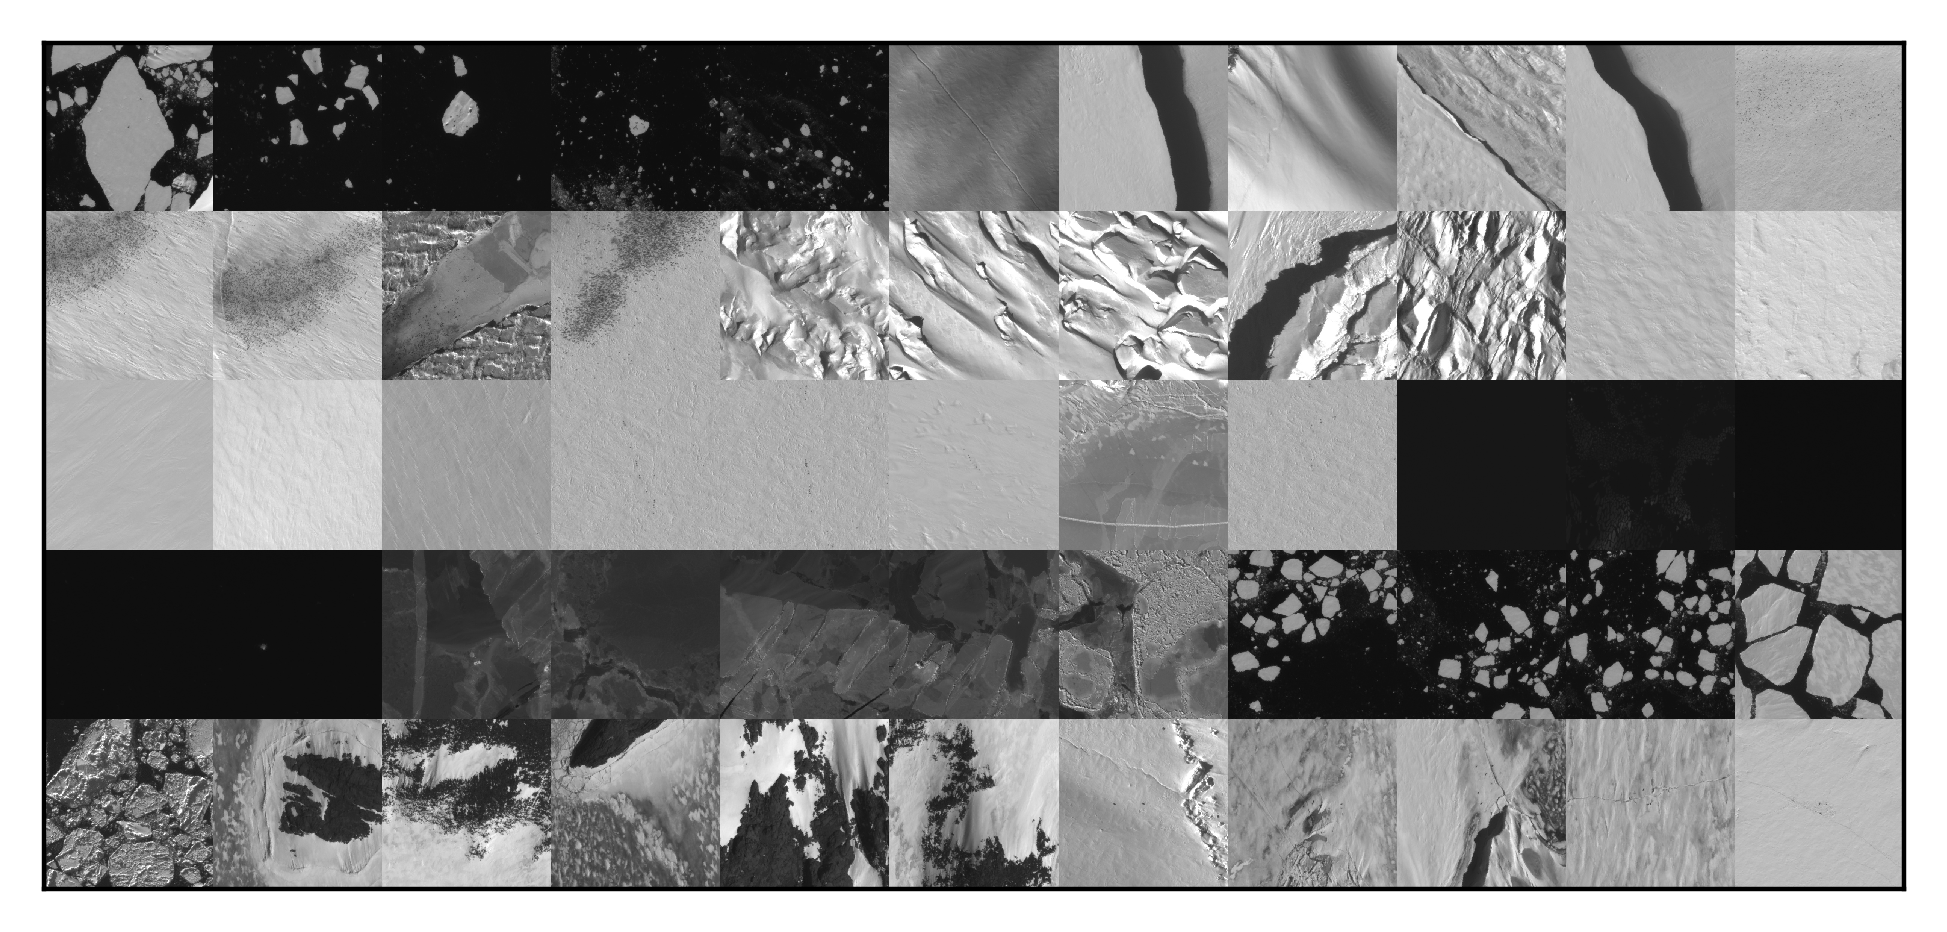

In [2]:
# store images
images = []

# loop over labels
for label in class_names:
    for path, _, files in os.walk('./training_sets/training_set_vanilla/training/{}'.format(label)):
        files = np.random.choice(files, 5)
        for filename in files:
            images.append(np.asarray(Image.open(os.path.join(path, filename))))

images = np.array(images)

# display images 
ncols=len(class_names)
nindex, height, width, intensity = images.shape
nrows = nindex//ncols
assert nindex == nrows*ncols
result = (images.reshape(nrows, ncols, height, width, intensity)
          .swapaxes(1,2)
          .reshape(height*nrows, width*ncols, intensity))

plt.imshow(result)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()
    


## Pipeline 1 - haulout detector<a name="1"></a>
---

The simplest pipeline we can use is one that just uses an object classification step to find seal haulouts or penguins colonies. The obvious downside for this approach is that we often have more than one seal in a haulout, which is hardly usefull if we are looking for a count. However, we will use this as a 'pre-preocessing' step, where we narrow down the totality of patches to the subset where the haulout detection CNN flagged groups of seals. To validate the usefulness of this preprocessing step we can compare results obtained with the full pipeline (i.e. haul out detector + count) to one that simply tries to count on all tiles. 

### Training<a name="1T"></a>

The first step to find a best performing model is to train different model setups using our training set. To keep track of which combinations we have tried, how well they performed and the specifics of each model setup, we will store results in folders (under './saved_models') named after each specific model combination.

In [3]:
# generate model combinations
combinations_1 = {'model_architecture': ['Resnet18', 'Resnet34', 'Resnet50', 'Squeezenet11',
                                         'Alexnet', 'NasnetA', 'Densenet121','Densenet169', 
                                         'VGG16'],
                  'training_dir': ['training_set_vanilla'] * 9,
                  'hyperparameter_set': ['A'] * 5 + ['B'] * 4,
                  'cv_weights': ['NO'] * 9}

# read as a DataFrame
combinations_1 = pd.DataFrame(combinations_1)
                    
# create folders for resulting files
for row in combinations_1.iterrows():
    mdl = row[1]['model_architecture']                  
    if not os.path.exists("./saved_models_stable/Pipeline1/{}".format(mdl)):
        os.makedirs("./saved_models_stable/Pipeline1/{}".format(mdl)) 


We can then provide model combinations created above as arguments to the training script, *train_sealnet.py*. A list of required arguments can be displayed by running the cell below.

In [4]:
%run train_sealnet.py -h

usage: train_sealnet.py [-h] [--training_dir TRAINING_DIR]
                        [--model_architecture MODEL_ARCHITECTURE]
                        [--hyperparameter_set HYPERPARAMETER_SET]
                        [--cv_weights [CV_WEIGHTS]]
                        [--output_name OUTPUT_NAME] [--pipeline PIPELINE]
                        [--dest_folder DEST_FOLDER]

trains a CNN to find seals in satellite imagery

optional arguments:
  -h, --help            show this help message and exit
  --training_dir TRAINING_DIR
                        base directory to recursively search for images in
  --model_architecture MODEL_ARCHITECTURE
                        model architecture, must be a member of models
                        dictionary
  --hyperparameter_set HYPERPARAMETER_SET
                        combination of hyperparameters used, must be a member
                        of hyperparameters dictionary
  --cv_weights [CV_WEIGHTS]
                        weights for weighted-cross

In [5]:
# iterate over combinations
pipeline = 'Pipeline1'
for row in combinations_1.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st, cv_wgt = row[1]['training_dir'], row[1]['model_architecture'], \
                                  row[1]['hyperparameter_set'], row[1]['cv_weights']
    out = arch
    
    # check if model is already trained
    if "{}.tar".format(out) in os.listdir('./saved_models_stable/{}/{}/'.format(pipeline, out)): 
        print('{} was already trained'.format(out))
        continue
    
    print()
    !echo training $out
    print()
    
    # run training
    !python train_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                             --hyperparameter_set=$hyp_st --cv_weights=$cv_wgt \
                             --output_name=$out --pipeline=$pipeline \
                             --dest_folder='saved_models_stable'
      

Resnet18 was already trained

training Resnet34

Epoch 1/5
----------
training Loss: 0.0502 training Acc: 0.6217
validation Loss: 0.3867 validation Acc: 0.6731
training time: 0.0h 23m 53s

Epoch 2/5
----------
training Loss: 0.0323 training Acc: 0.7685
validation Loss: 0.5680 validation Acc: 0.5777
training time: 0.0h 47m 35s

Epoch 3/5
----------
training Loss: 0.0210 training Acc: 0.8571
validation Loss: 0.2007 validation Acc: 0.8411
training time: 1.0h 11m 16s

Epoch 4/5
----------
training Loss: 0.0155 training Acc: 0.8942
validation Loss: 0.2071 validation Acc: 0.8642
training time: 1.0h 34m 57s

Epoch 5/5
----------
training Loss: 0.0128 training Acc: 0.9127
validation Loss: 0.2595 validation Acc: 0.7917
training time: 1.0h 58m 39s

Training complete in 1.0h 58m 39s

training Resnet50

Epoch 1/5
----------
training Loss: 0.0529 training Acc: 0.6110
validation Loss: 0.6198 validation Acc: 0.5995
training time: 0.0h 42m 48s

Epoch 2/5
----------
training Loss: 0.0295 training Acc: 

### Validation<a name="1V"></a> 

We can now load the models we just trained to get measurements of precision and recall for all positive classes. For every model combination we trained, *validate_sealnet.py* will run a full validation round and write given label/correct label pairs to a .csv file. The resulting .csv file is then imported by an R script, *plot_confusion_matrix.R*, which saves a confusion matrix figure and a .csv spreadsheet with precision and recall for all classes of interest. 

In [6]:
# DataFrame to combine all metrics 
comb_prec_recall = pd.DataFrame()
pipeline = 'Pipeline1'

# iterate over trained models
for row in combinations_1.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st, cv_wgt = row[1]['training_dir'], row[1]['model_architecture'],\
                                  row[1]['hyperparameter_set'], row[1]['cv_weights']
    out = arch
    
    # check if model file is available
    if "{}.tar".format(out) not in os.listdir('./saved_models_stable/{}/{}/'.format(pipeline, out)): 
        print('{} has not been trained yet'.format(out))
        continue
        
    else:
        print()
        !echo validating $out
        print()
        
        #run validation
        !python validate_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                                    --hyperparameter_set=$hyp_st --model_name=$out \
                                    --pipeline=$pipeline --dest_folder='saved_models_stable'
        
        # extract performance metrics and plot confusion matrix
        !Rscript plot_confusion_matrix.R --input_file=$out --pipeline=$pipeline \
                                         --dest_folder='saved_models_stable'
        
        # accumulate performance scores
        comb_prec_recall = comb_prec_recall.append(pd.read_csv('./saved_models_stable/{}/{}/{}_prec_recall.csv'.format(pipeline, out, out)))
    
    
# Write combined metrics to csv and plot combined metrics
pooled_data_path = './saved_models_stable/{}/pooled_prec_recall.csv'.format(pipeline)
comb_prec_recall.to_csv(pooled_data_path)
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1/comparison_plot.png' \
                           --x='recall' --y='precision' --facet='label'
    


validating Resnet18

Validation complete in 0.0h 0m 29s
Validation Acc: 0.822759

validating Resnet34

Validation complete in 0.0h 0m 46s
Validation Acc: 0.791677

validating Resnet50

THCudaCheck FAIL file=/opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/THC/generic/THCStorage.cu line=58 error=2 : out of memory
Traceback (most recent call last):
  File "validate_sealnet.py", line 184, in <module>
    main()
  File "validate_sealnet.py", line 180, in main
    num_workers=hyperparameters[args.hyperparameter_set]['num_workers_train'])
  File "validate_sealnet.py", line 119, in validate_model
    outputs = model(inputs)
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py", line 491, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/resnet.py", line 144, in forward
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torch/nn/modules/

FileNotFoundError: File b'./saved_models_stable/Pipeline1/Resnet50/Resnet50_prec_recall.csv' does not exist

## Pipeline 1.1 - haulout detector + count<a name="1.1"></a>
---

Here we will generate seal counting CNNs, train them and validate them. Seal counting CNNs will be trained to minimize the mean squared error (MSE) between predicted counts and ground-truth counts. Though they will be trained and validated separately from the haul out detector (Pipeline 1), these approaches will be tested on top of the haul out detector and as standalones.

### Training<a name="1.1T"></a>

Similar to the previous pipeline, we will store results in folders (under './saved_models') named after each specific model combination for bookkeeping.

In [ ]:
# generate model combinations
combinations_11 = {'model_architecture': ['WideResnetCount', 'Resnet34count', \
                                          'Resnet18count', 'Resnet50count', \
                                          'NasnetAcount', 'CountCeption'],
                   'training_dir': ['training_set_vanilla'] * 6,
                   'hyperparameter_set': ['D'] + ['A'] * 3 + ['B'] * 2}
        

# read as a DataFrame
combinations_11 = pd.DataFrame(combinations_11)
                    

# create folders for resulting files
for row in combinations_11.iterrows():
    mdl = row[1]['model_architecture']                     
    if not os.path.exists("./saved_models_stable/Pipeline1.1/{}".format(mdl)):
        os.makedirs("./saved_models_stable/Pipeline1.1/{}".format(mdl)) 

To train a counting model, model combinations created above are used as argument to to a new training script, *train_sealnet_count.py*, which uses MSE loss. It accepts the same arguments as the previous.

In [ ]:
# iterate over combinations
pipeline = 'Pipeline1.1'
for row in combinations_11.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st = row[1]['training_dir'], row[1]['model_architecture'], \
                          row[1]['hyperparameter_set']
    out = arch
    
    # check if model is already trained
    if "{}.tar".format(out) in os.listdir('./saved_models_stable/{}/{}/'.format(pipeline, out)): 
        print('{} was already trained'.format(out))
        continue
    
    print()
    !echo training $out
    print()
    
    # run training
    !python train_sealnet_count.py --training_dir=$t_dir --model_architecture=$arch \
                                   --hyperparameter_set=$hyp_st --output_name=$out  \
                                   --pipeline=$pipeline
    

### Validation<a name="1.1V"></a>

Validating counting models is a little bit simpler then with seal haul out models: for each model we just extract the mean squared error, running time at inference and number of model parameters. To test if classifying images before counting is helpful, performance stats during counting validation will be later compared to those where images where classified prior to counting.


In [ ]:
# DataFrame to combine all metrics 
comb_mse = pd.DataFrame()
pipeline = 'Pipeline1.1'

# iterate over trained models
for row in combinations_11.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st = row[1]['training_dir'], row[1]['model_architecture'],\
                          row[1]['hyperparameter_set']
    out = arch
    
    # check if model file is available
    if "{}.tar".format(out) not in os.listdir('./saved_models_stable/{}/{}/'.format(pipeline, out)): 
        print('{} has not been trained yet'.format(out))
        continue
    
    else:
        print()
        !echo validating $out
        print()
        
        #run validation
        !python validate_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                                    --hyperparameter_set=$hyp_st --model_name=$out \
                                    --pipeline=$pipeline --dest_folder='saved_models_stable'
        
        # extract performance metrics and plot confusion matrix
        !Rscript get_mse.R --input_file=$out --pipeline=$pipeline --dest_folder='saved_models_stable'
    
        # accumulate performance scores
        comb_mse = comb_mse.append(pd.read_csv('./saved_models_stable/{}/{}/{}_mse.csv'.format(pipeline, out, out)))
    
# generate counting benchmarks and add them to the combined metrics DataFrame
!Rscript generate_benchmarks.R --input_file='Resnet18count' --pipeline=$pipeline \
                               --dest_folder='saved_models_stable'
comb_mse = comb_mse.append(pd.read_csv('./saved_models_stable/{}/benchmarks.csv'.format(pipeline)))

# write combined metrics to csv and plot combined metrics
pooled_data_path = './saved_models_stable/{}/pooled_mse.csv'.format(pipeline)
comb_mse.to_csv(pooled_data_path)

# total predicted vs ground-truth plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_final_count.png' \
                           --x='total_predicted' --y='total_ground_truth'
        
# inference time vs. MSE plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_mse.png' \
                           --x='running_time' --y='MSE'

# precision vs. recall plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_prec_recall.png' \
                           --x='recall' --y='precision'

### Testing -- ablation study<a name="1.1T"></a>

The idea of this step is to test the validity of the full pipeline (classify + count) against one that will simply count in every patch. To do that we will run *predict_sealnet.py* on our validation images with the best classification model from pipeline 1, keep the names of those that have any seals in it and get the MSE of counting models on that subset. We will then copy positive images to ablation sets. 

In [ ]:
# check whether images were already classified
if 'classified_patches.csv' not in os.listdir('./saved_models_stable/Pipeline1/'):
    
    # extract best performing model from Pipeline 1
    pooled_stats = pd.read_csv('./saved_models_stable/Pipeline1/pooled_prec_recall.csv')
    
    model_scores = {model: 0 for model in pd.unique(pooled_stats['model_name'])}
    for mdl in model_scores:
        model_scores[mdl] += sum(pooled_stats.loc[pooled_stats['model_name'] == mdl, 'precision']) \
                             +  sum(pooled_stats.loc[pooled_stats['model_name'] == mdl, 'recall'])
    
    # get model with highest precision and recall across all positive classes
    model_choice = max(model_scores.items(), key=operator.itemgetter(1))[0]
    print('\nBest performing model: {}'.format(model_choice))

    # classify validation images with a model from Pipeline 1
    !python predict_sealnet_ablation.py --pipeline='Pipeline1' \
                                        --model_architecture=$model_choice \
                                        --training_dir='training_set_vanilla' \
                                        --hyperparameter_set='B' \
                                        --model_name=$model_choice \
                                        --positive_classes='crabeater_weddell' \
                                        --dest_folder='saved_models_stable'

# load csv with list of classified images
to_count = pd.read_csv('./saved_models_stable/Pipeline1/classified_patches.csv')['file'].values

# create ablation experiment folder inside training_sets
for ts in ['training_set_vanilla', 'training_set_multiscale_A']:
    if not os.path.exists("./training_sets/{}_ablation/validation/pos_patches".format(ts)):
        os.makedirs("./training_sets/{}_ablation/validation/pos_patches".format(ts)) 
    # copy images flagged as positive to ablation experiment set folders
    for path, _, files in os.walk('./training_sets/{}'.format(ts)):
        for filename in files:
            if filename in to_count:
                file_path = os.path.join(path, filename)
                img = Image.open(file_path)
                img.save('./training_sets/{}_ablation/validation/pos_patches/{}'.format(ts, filename))
        
print('\nAblation experiment set completed')

We can now loop through positive patches with counting CNNs, get MSE and total count for positive images and compare results with those of Pipeline1.1 validation (pura counting pipeline). 

In [ ]:
# Create DataFrame to combine metrics
comb_mse = pd.DataFrame()
pipeline = 'Pipeline1.1'

# iterate over trained models
for row in combinations_11.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st = row[1]['training_dir'], row[1]['model_architecture'],\
                          row[1]['hyperparameter_set']
    out = arch
    
    # check if model file is available
    if "{}.tar".format(out) not in os.listdir('./saved_models_stable/{}/{}/'.format(pipeline, out)): 
        print('{} has not been trained yet'.format(out))
        continue
        
    else:
        print()
        !echo validating $out
        print()
        
        #run validation
        !python validate_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                                    --hyperparameter_set=$hyp_st --model_name=$out \
                                    --pipeline=$pipeline --ablation=1 \
                                    --dest_folder='saved_models_stable'
        
        # extract performance metrics and plot confusion matrix
        !Rscript get_mse.R --input_file=$out --pipeline=$pipeline \
                           --dest_folder='saved_models_stable'
        
        # accumulate performance scores
        comb_mse = comb_mse.append(pd.read_csv('./saved_models_stable/{}/{}/{}_mse.csv'.format(pipeline, out, out)))
    
    
# generate counting benchmarks and add them to the combined metrics DataFrame
!Rscript generate_benchmarks.R --input_file='Resnet18count' --pipeline=$pipeline \
                               --dest_folder='saved_models_stable'
comb_mse = comb_mse.append(pd.read_csv('./saved_models_stable/{}/benchmarks.csv'.format(pipeline)))

# write combined metrics to csv and plot combined metrics
pooled_data_path = './saved_models_stable/{}/pooled_mse.csv'.format(pipeline)
comb_mse.to_csv(pooled_data_path)

# total predicted vs ground-truth plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_final_count_ablation.png' \
                           --x='total_predicted' --y='total_ground_truth'
        
# inference time vs. MSE plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_mse_ablation.png' \
                           --x='running_time' --y='MSE'

# precision vs. recall plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_prec_recall_ablation.png' \
                           --x='recall' --y='precision'

## Pipeline 1.2 - haulout detector + single seal detector<a name="1.2"></a>
---

Pipeline 1.2 adds an individual seal detection CNN on top of the seal haul out detector (Pipeline 1. Individual seal detection CNNs will be trained to localize detection points and minimize the MSE between the number of detections and ground-truth count. In this approach, counts will be obtained by adding up the number of detections. Though they will be trained and validated separately from the haul out detector (Pipeline 1), these approaches will be tested on top of the haul out detector and as standalones.

### Training<a name="1.2T"></a>

### Validation<a name="1.2V"></a>

### Testing -- ablation study<a name="1.2T"></a>